## Auto-encoders 

Author : Ines Krissaane 

In [71]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense,  Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Lambda, Flatten, Activation, Dropout
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve,auc

## Import data and pre-processing (cf 1.Pre-processing.ipynb and 2.RandomForest.ipynb)

In [49]:
X_tr = pd.read_csv('sepsis_data_all.csv')
X_tr.shape

(1552210, 44)

In [50]:
# Remove variables with more than 82% of na.
X_tr.drop(['EtCO2', 'BaseExcess','HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos',
    'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct' ,'Lactate','Magnesium','Phosphate',
    'Potassium', 'Bilirubin_total', 'TroponinI','Hct', 'Hgb','PTT',  'WBC', 'Unnamed: 0','Fibrinogen', 'Platelets',
    "Glucose", 'Unit1', "Unit2", "HospAdmTime",'X', 'DBP', 'SBP', 'O2Sat'], axis = 1, inplace = True)

In [51]:
X_tr.fillna(method='bfill', inplace=True)
X_tr.fillna(method='ffill', inplace=True)

In [46]:
X_tr.head()

,HR,Temp,MAP,Resp,Age,Gender,ICULOS,SepsisLabel
0,97.0,36.11,75.33,19.0,83.14,0,1,0
1,97.0,36.11,75.33,19.0,83.14,0,2,0
2,89.0,36.11,86.00,22.0,83.14,0,3,0
3,90.0,36.11,91.33,30.0,83.14,0,4,0
4,103.0,36.11,91.33,24.5,83.14,0,5,0


## Anomaly Detection using Autoencoders

- https://arxiv.org/pdf/1811.05269.pdf
- https://core.ac.uk/download/pdf/81634504.pdf

In [52]:
normal = X_tr[X_tr['SepsisLabel'] == 0]
anormal = X_tr[X_tr['SepsisLabel'] == 1]

list_anormal = list(anormal.ID.unique() )
list_normal = list(normal.ID.unique() )
df = X_tr
for i in (list_anormal):
    df = df[df.ID != i]

normal = df
list_normal = list(normal.ID.unique())

In [53]:
normal.drop(['ID'], axis = 1, inplace = True)

In [54]:
normal.shape

(1277881, 8)

In [57]:
# train only on healthy patients 
RANDOM_SEED = 101
X_train, X_test = train_test_split(normal, test_size=0.3, random_state = RANDOM_SEED)
y_train = X_train.SepsisLabel
X_train.drop(['SepsisLabel'], axis=1,  inplace = True)
y_test = pd.concat([X_test.SepsisLabel,anormal.SepsisLabel])
X_test = pd.concat([X_test, anormal], axis=0)
X_test.drop(['SepsisLabel', 'ID'], axis=1,  inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [58]:
X_train = X_train.values
X_test  = X_test.values
print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)
      

Training data size   : (894516, 7)
Validation data size : (411281, 7)


In [59]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [60]:
# Our NN
input_dim = X_train.shape[1]
encoding_dim = 56

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="softmax")(input_layer)
encoder = Dense(int(encoding_dim * 7), activation="softmax")(encoder)
#encoder = Dense(int(2), activation="tanh")(encoder)
#decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='softmax')(encoder)
decoder = Dense(input_dim, activation='softmax')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

W0831 13:25:42.490810 4756096448 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense (Dense)                (None, 56)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 392)               22344     
_________________________________________________________________
dense_2 (Dense)              (None, 56)                22008     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 399       
Total params: 45,199
Trainable params: 45,199
Non-trainable params: 0
_________________________________________________________________


In [63]:
# train it
nb_epoch = 100
batch_size = 1000
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 894516 samples, validate on 411281 samples
Epoch 1/100
894516/894516 [==============================] - 6s 6us/sample - loss: 3011.5729 - acc: 0.3778 - val_loss: 3072.7074 - val_acc: 0.0958
Epoch 2/100
894516/894516 [==============================] - 6s 7us/sample - loss: 3007.0079 - acc: 0.4881 - val_loss: 3073.0159 - val_acc: 0.0958
Epoch 3/100
894516/894516 [==============================] - 6s 7us/sample - loss: 3006.5396 - acc: 0.4881 - val_loss: 3074.1697 - val_acc: 0.0958
Epoch 4/100
894516/894516 [==============================] - 7s 7us/sample - loss: 3006.4771 - acc: 0.4881 - val_loss: 3074.6297 - val_acc: 0.0958
Epoch 5/100
894516/894516 [==============================] - 7s 7us/sample - loss: 3006.4571 - acc: 0.4881 - val_loss: 3074.8512 - val_acc: 0.0958
Epoch 6/100
894516/894516 [==============================] - 6s 7us/sample - loss: 3006.4482 - acc: 0.4881 - val_loss: 3074.9732 - val_acc: 0.0958
Epoch 7/100
894516/894516 [==============================] - 7s 7u

894516/894516 [==============================] - 6s 7us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.1943 - val_acc: 0.0958
Epoch 57/100
894516/894516 [==============================] - 6s 7us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.1943 - val_acc: 0.0958
Epoch 58/100
894516/894516 [==============================] - 6s 7us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.1943 - val_acc: 0.0958
Epoch 59/100
894516/894516 [==============================] - 6s 7us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.1943 - val_acc: 0.0958
Epoch 60/100
894516/894516 [==============================] - 7s 7us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.1943 - val_acc: 0.0958
Epoch 61/100
894516/894516 [==============================] - 7s 8us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.1943 - val_acc: 0.0958
Epoch 62/100
894516/894516 [==============================] - 7s 7us/sample - loss: 3006.4363 - acc: 0.4881 - val_loss: 3075.

In [80]:
# save model 
autoencoder = load_model('autoencoder_fraud.h5')

W0831 13:42:56.267539 4756096448 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0831 13:42:56.268622 4756096448 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Model results

In [69]:
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test- test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,411281.000000,411281.000000
mean,3075.194239,0.067876
std,994.673420,0.251533
min,901.669998,0.000000
25%,2546.168969,0.000000
50%,2930.857142,0.000000
75%,3394.399988,0.000000
max,20535.238201,1.000000


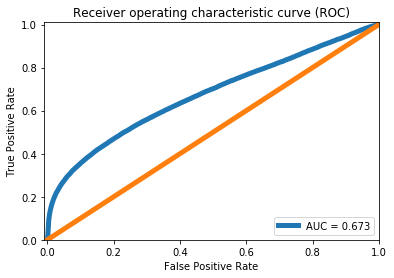

In [72]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

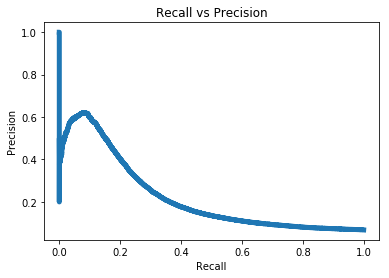

In [73]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

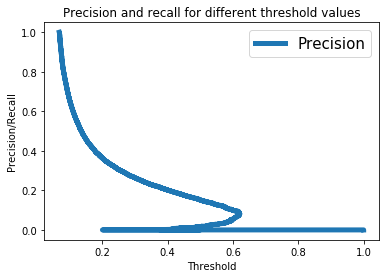

In [85]:
plt.plot( precision_rt[1:], recall_rt[1:],label="Precision",linewidth=5)

plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

## Test for patients with sepsis

In [75]:
d = pd.concat([error_df.iloc[1:500,],error_df.iloc[410781:411281,]], axis=0)
d.shape

(999, 2)

In [92]:
d

,Reconstruction_error,True_class
985485,2553.428567,0
4972,2424.825857,0
1518811,3275.464252,0
1320222,3693.428565,0
171258,2148.969650,0
687203,2235.929480,0
918859,4564.115706,0
1132767,3335.519980,0
471104,3878.173934,0
579850,2083.217279,0


In [93]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(d.True_class, d.Reconstruction_error)

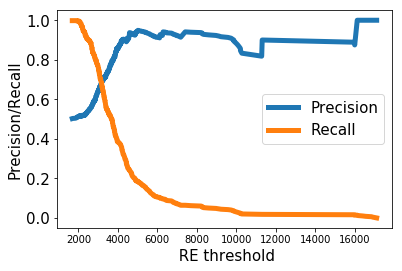

In [96]:
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
#plt.title('Precision and recall for different threshold values', size = 20)
plt.xlabel(' RE threshold', size = 15)
plt.ylabel('Precision/Recall', size = 15)
plt.yticks(size = 15);
plt.legend()

plt.savefig('precisionrecall.png')

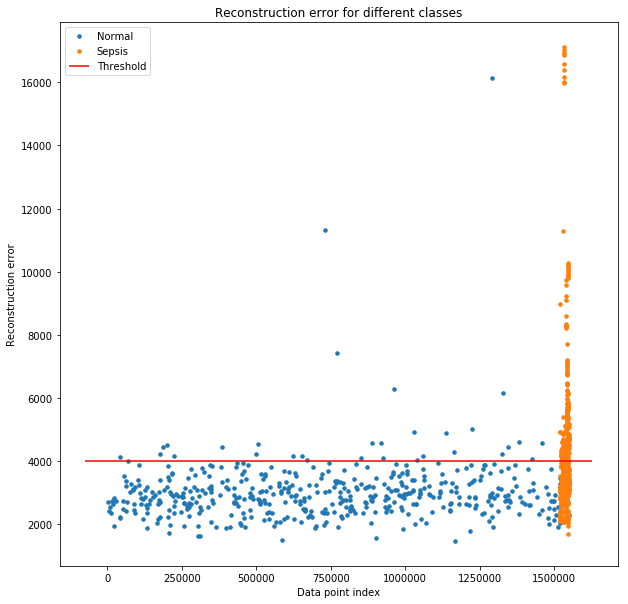

In [77]:
threshold_fixed = 4000
groups = d.groupby('True_class')
fig, ax = plt.subplots(figsize=(10,10))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Sepsis" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

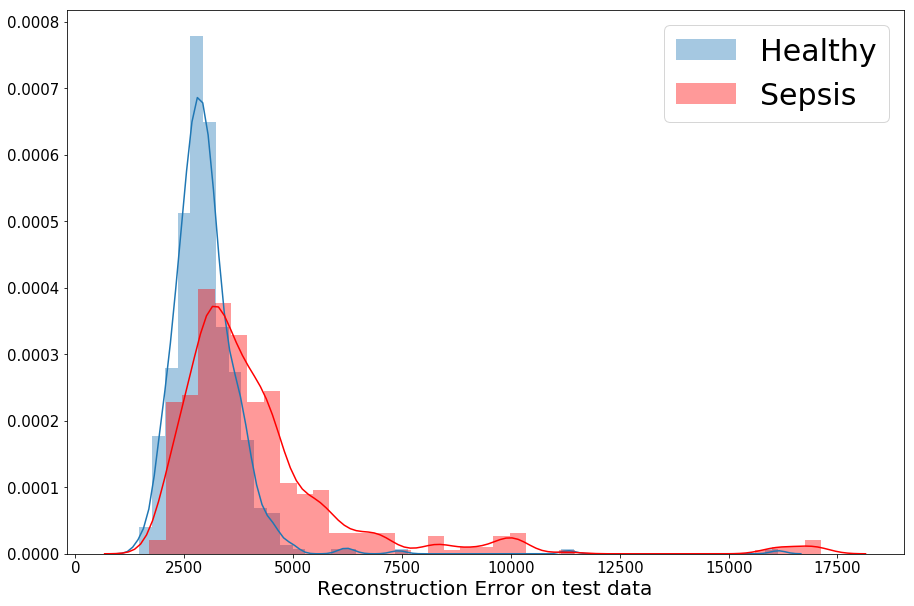

In [84]:
fig = plt.subplots(figsize=(15, 10))
sns.distplot(d[d["True_class"]==0].Reconstruction_error,  rug=False, label="Healthy")
sns.distplot(d[d["True_class"]==1].Reconstruction_error, rug=False,  label="Sepsis",  color='red');
plt.legend(loc=1, prop={'size': 30})
plt.xticks(size =15)
plt.rc('legend', fontsize=15)   
#plt.title("Reconstruction Error on Test data", size =20)
plt.xlabel('Reconstruction Error on test data', size = 20)
plt.savefig('imbalanced_dataset.png')
plt.yticks(size = 15);
plt.savefig('autoencoder.png')

In [109]:
# create another feature RE
data = X_tr
y = data.SepsisLabel
data.drop(['SepsisLabel','ID'], axis = 1, inplace = True)

In [113]:
data = data.values

In [114]:
allpredictions = autoencoder.predict(data)


In [115]:
mse = np.mean(np.power(data- allpredictions, 2), axis=1)
f = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class':y})
f.describe()

,Reconstruction_error,True_class
count,1.552210e+06,1.552210e+06
mean,3.117094e+03,1.798468e-02
std,1.059795e+03,1.328956e-01
min,8.978266e+02,0.000000e+00
25%,2.553953e+03,0.000000e+00
50%,2.947676e+03,0.000000e+00
75%,3.428009e+03,0.000000e+00
max,2.054187e+04,1.000000e+00


In [117]:
len(f.Reconstruction_error)

1552210

In [118]:
np.savetxt("REfromAENN.csv", f.Reconstruction_error, fmt='%s')